<a href="https://colab.research.google.com/github/rndbblnn/stonks-jupyter/blob/main/tz_trades.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
!pip install yfinance
!pip install mplfinance

import yfinance as yf
import mplfinance as mpf
import matplotlib.pyplot as plt
import matplotlib.image  as m_img
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np 
import json
import requests
import urllib.parse
import base64
import warnings
import logging
import io
from datetime import datetime
from PIL import Image

warnings.filterwarnings('ignore')

# baseurl = 'https://af1bbf696a14.ngrok.io';
baseurlchart = "http://localhost:8081"
baseurltrades = "http://localhost:8080"

def encodeUrl(arg):
  str = arg.replace('.','%2E')
  return urllib.parse.quote(str)

def getChartDataframe(symbol, timeframe, datefrom, dateto):
    url = baseurlchart + '/chart/' + symbol + '/' + timeframe + '?from=' + encodeUrl(datefrom) + '&to=' + encodeUrl(dateto)
    print('symbol=' + symbol + ", timeframe=" + timeframe + ", datefrom=" + str(datefrom)+ ", dateto=" + str(dateto))

    chartResponse = requests.get(url)
    df = None
    try:
      df = pd.DataFrame(chartResponse.json()['payload'])
      df.tickTime = pd.to_datetime(df.tickTime)
      df = df.set_index('tickTime')
      return df;
    except Exception as e:
      print(e.__class__)
      print(e)
      print(chartResponse)
      print(chartResponse.text)
      print('symbol=' + symbol + ", timeframe=" + timeframe + ", datefrom=" + str(datefrom)+ ", dateto=" + str(dateto))
      return;

dummyImg = Image.new('RGB', (60, 30), color = 'black')
dummyImg.save('void.png')


In [10]:
try:
  r = requests.get(baseurltrades + '/trades')
  df = pd.DataFrame(r.json()['payload'])
except Exception as e:
  logging.error(f"Exception Name: {type(e).__name__}")
  logging.error(f"Exception Desc: {e}")
  print(r)
  print(r.text)
  raise e

df['entryTime'] = pd.to_datetime(df['entryTime'])
df['exitTime'] = pd.to_datetime(df['exitTime'])

,id,symbol,side,created,qty,price,fees
execTime,,,,,,,
2022-11-16,197287455,ACRS,B_LONG,2022-11-24T09:30:03.508257,100,18.94,0.99
2022-11-16,197287485,ACRS,S_SELL,2022-11-24T09:30:03.520257,100,17.57,0.99


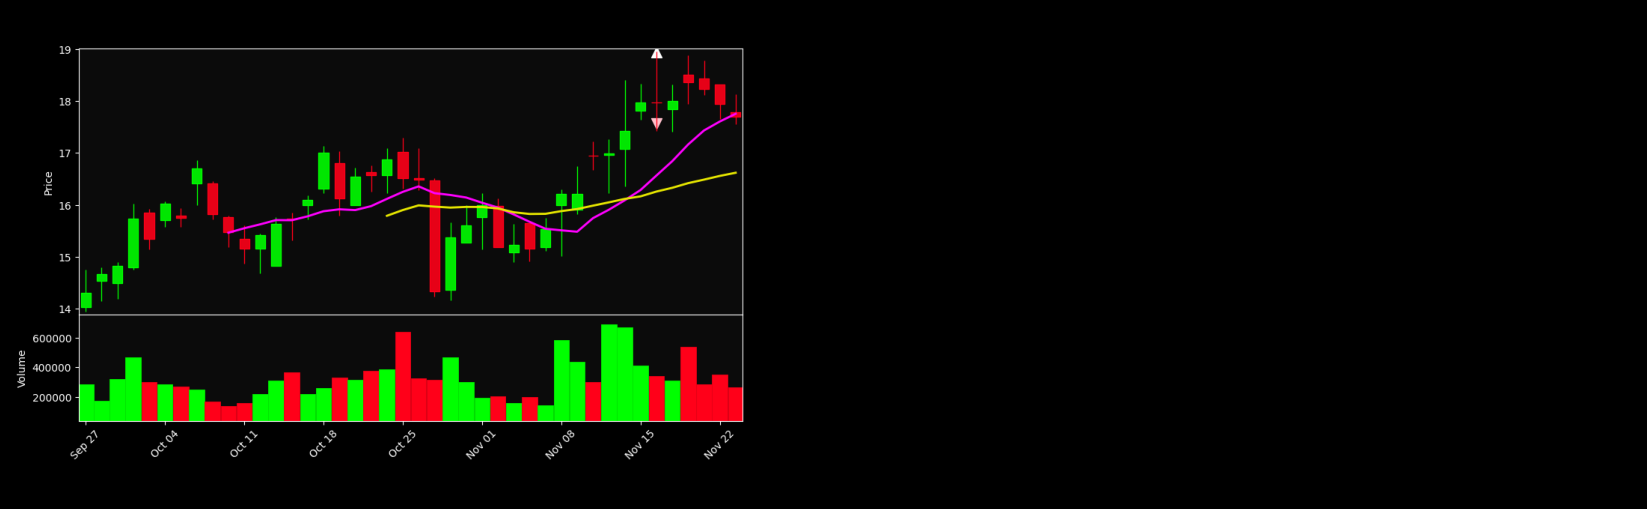

,id,symbol,side,created,qty,price,fees
execTime,,,,,,,
2022-11-16,197287486,AEHR,B_LONG,2022-11-24T09:30:03.521259,40,22.86,0.99
2022-11-16,197287487,AEHR,S_SELL,2022-11-24T09:30:03.521259,40,22.59,0.99


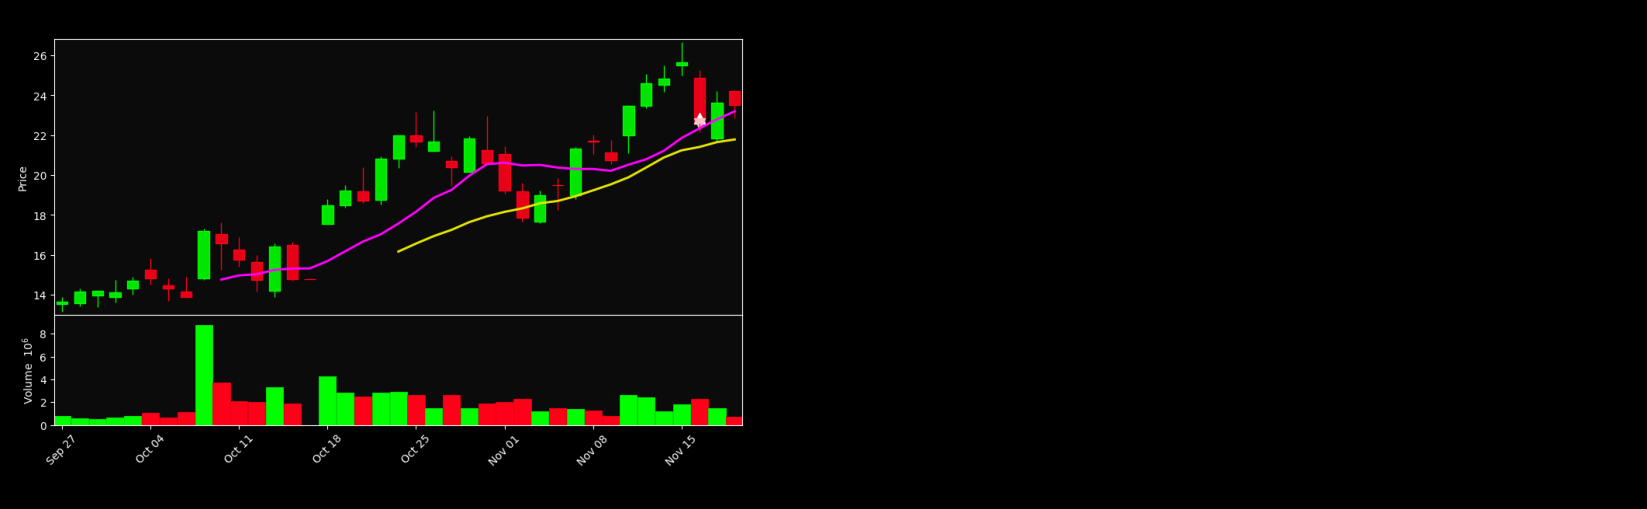

,id,symbol,side,created,qty,price,fees
execTime,,,,,,,
2022-11-08,197287059,ALB,B_LONG,2022-11-24T09:30:03.299625,10,290.96,0.99
2022-11-11,197287246,ALB,S_SELL,2022-11-24T09:30:03.422258,3,323.34,0.99
2022-11-15,197287377,ALB,S_SELL,2022-11-24T09:30:03.475263,7,290.66,0.99


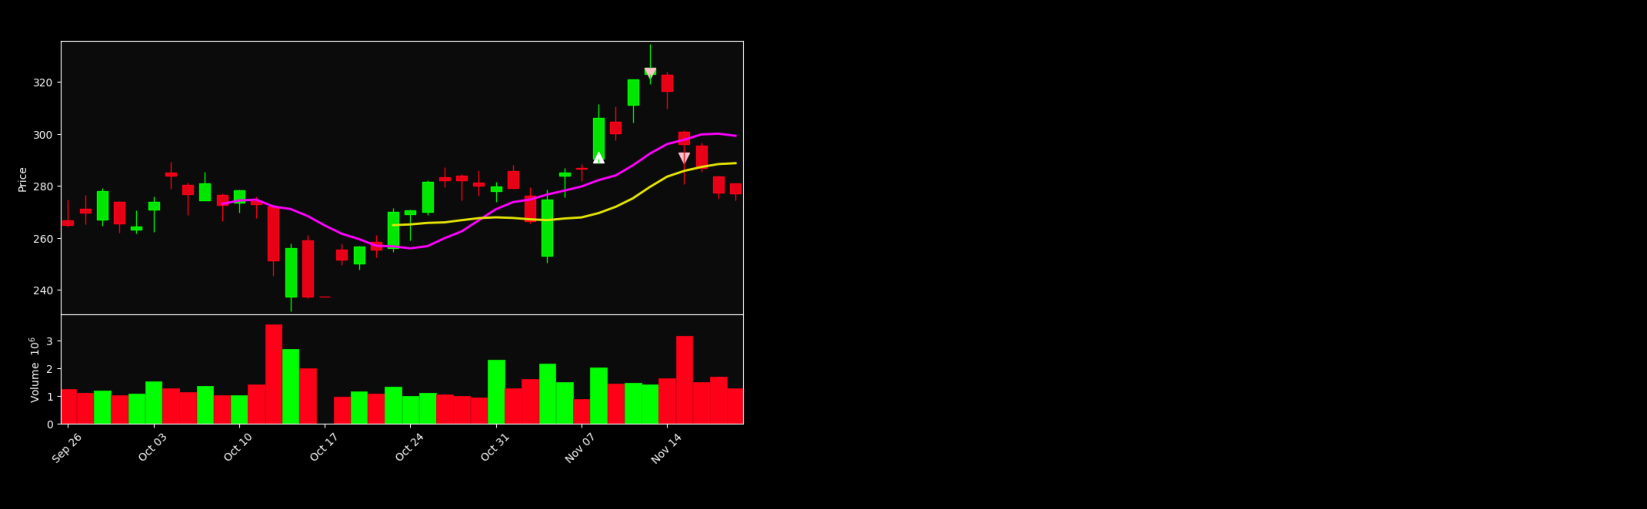

,id,symbol,side,created,qty,price,fees
execTime,,,,,,,
2022-11-18,197287599,AMC,SS_SHORTSELL,2022-11-24T09:30:03.628258,100,7.69,0.99
2022-11-18,197287644,AMC,BC_COVEREDBUY,2022-11-24T09:30:03.650258,100,7.41,0.99


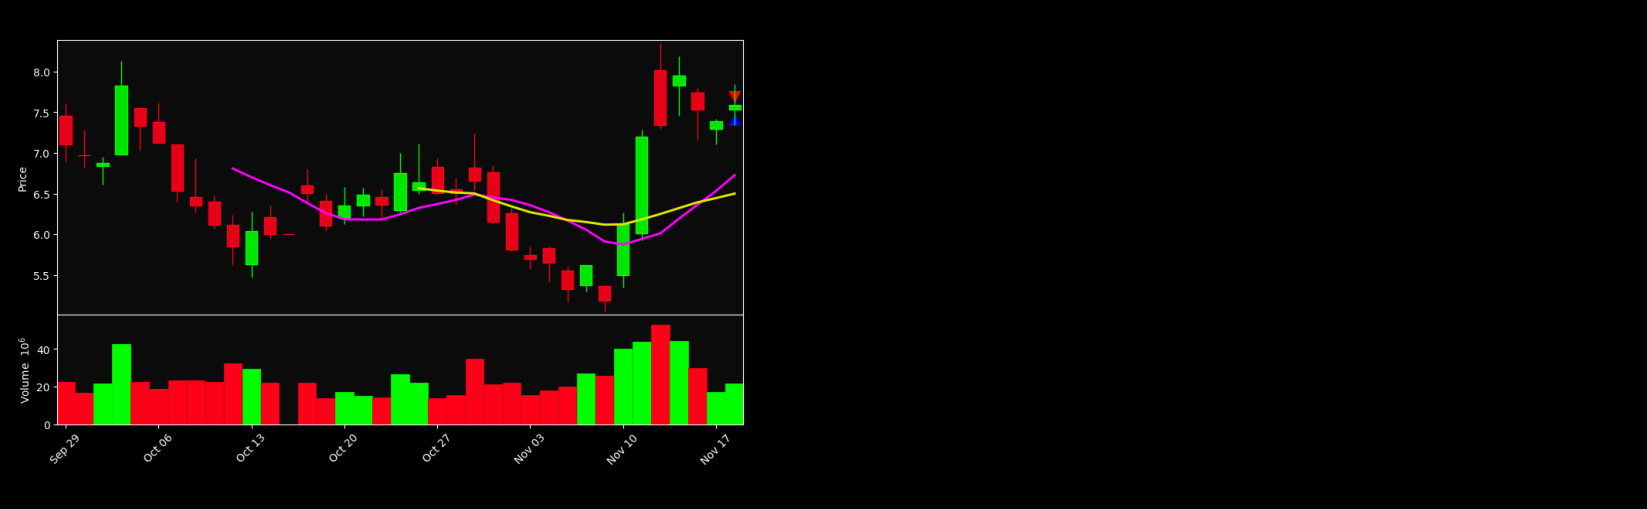

,id,symbol,side,created,qty,price,fees
execTime,,,,,,,
2022-11-11,197287293,AMPX,B_LONG,2022-11-24T09:30:03.442258,200,11.05,0.0
2022-11-14,197287306,AMPX,S_SELL,2022-11-24T09:30:03.448259,200,10.61,1.0


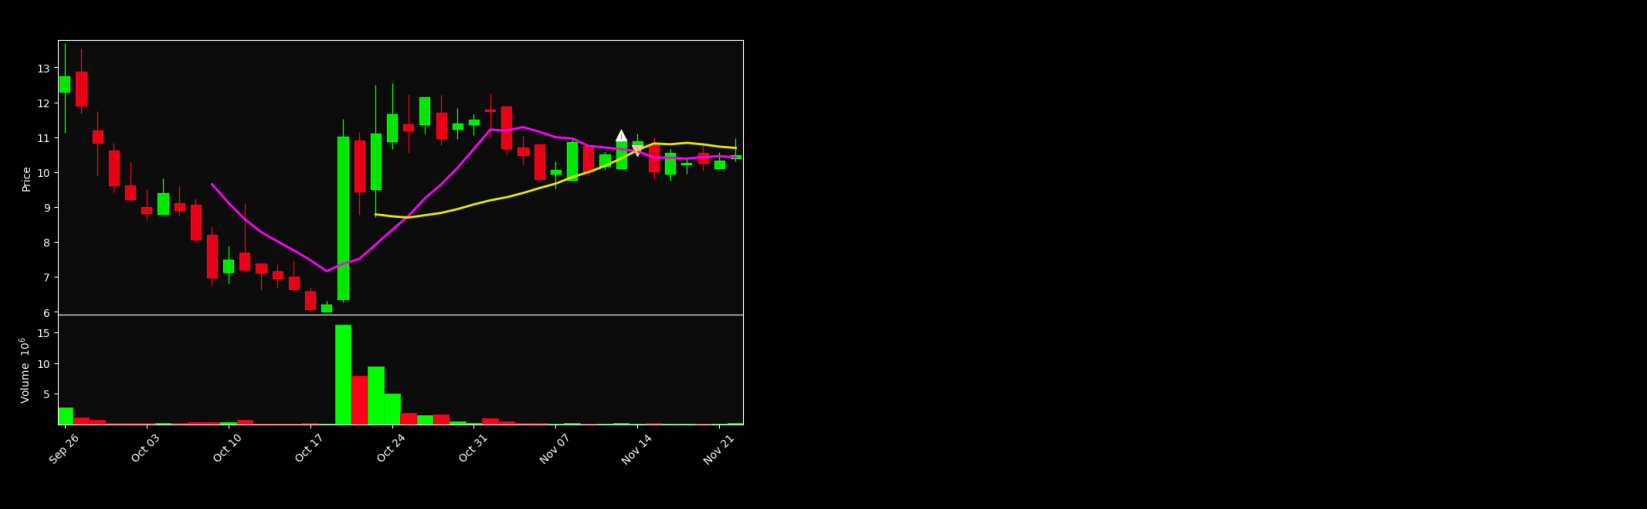

,id,symbol,side,created,qty,price,fees
execTime,,,,,,,
2022-11-14,197287300,ANET,B_LONG,2022-11-24T09:30:03.445259,40,129.27,0.99
2022-11-15,197287418,ANET,S_SELL,2022-11-24T09:30:03.492258,40,132.69,0.99


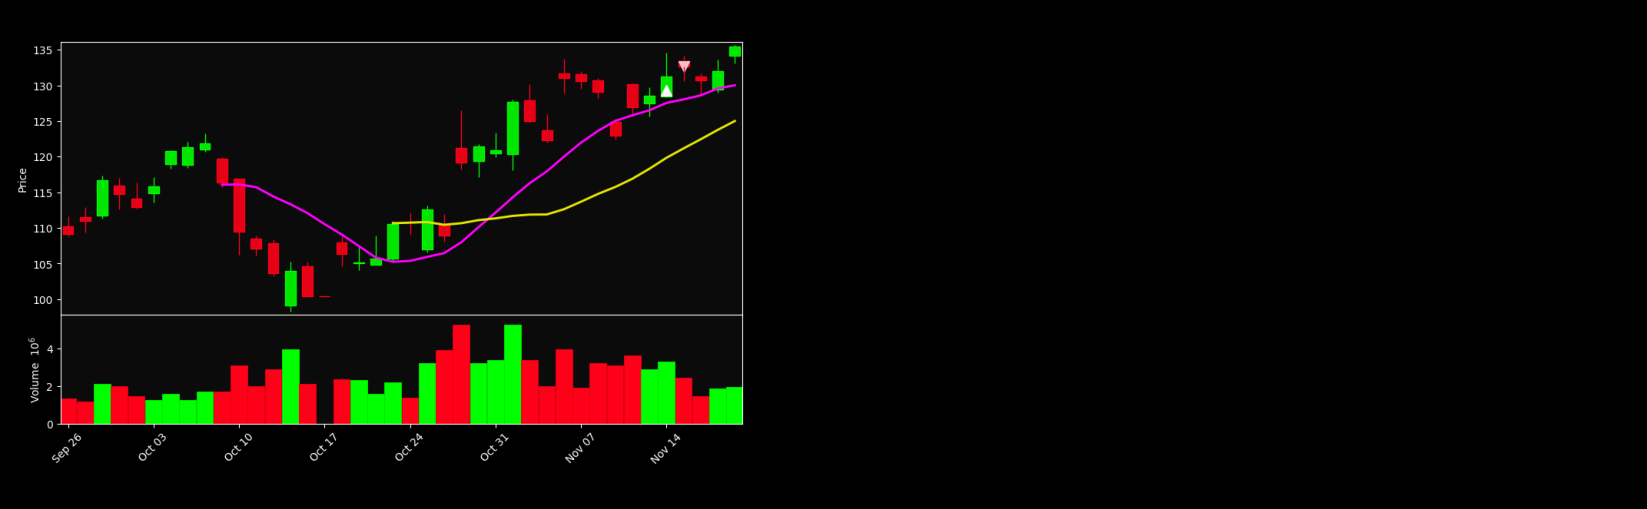

,id,symbol,side,created,qty,price,fees
execTime,,,,,,,
2022-11-14,197287303,ASC,B_LONG,2022-11-24T09:30:03.446258,100,13.89,0.99
2022-11-15,197287389,ASC,B_LONG,2022-11-24T09:30:03.479259,100,13.97,0.99
2022-11-16,197287451,ASC,S_SELL,2022-11-24T09:30:03.506257,200,13.67,1.00


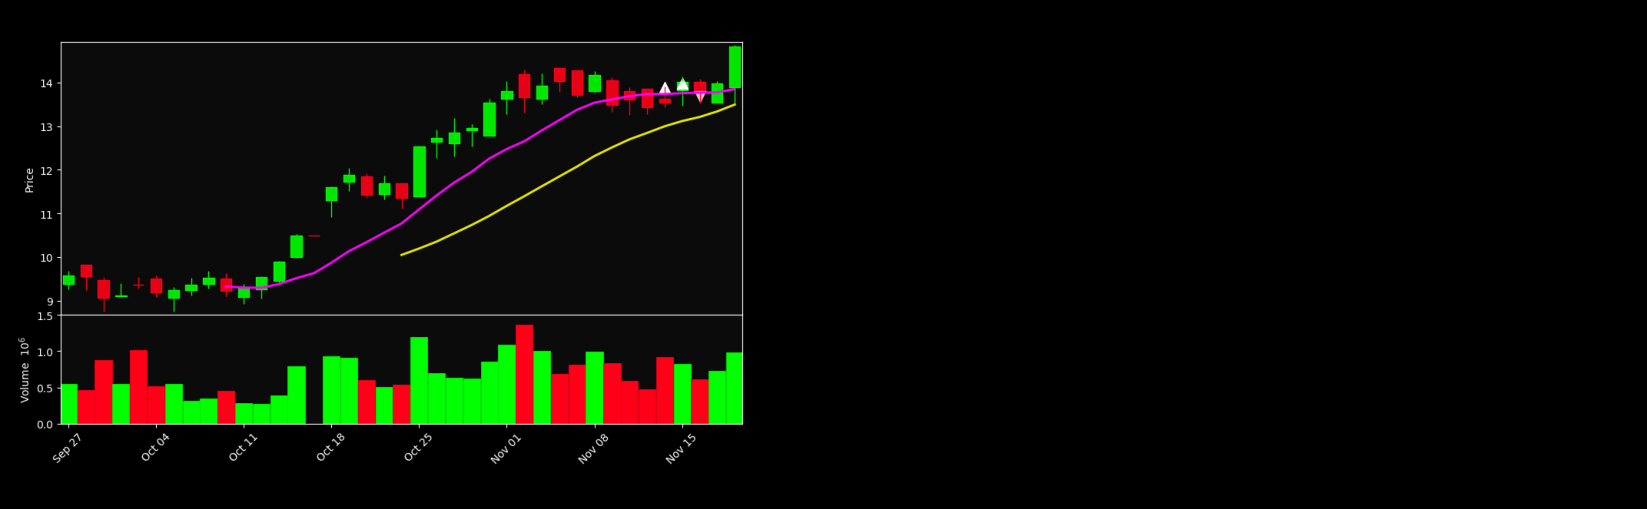

,id,symbol,side,created,qty,price,fees
execTime,,,,,,,
2022-11-18,197287602,ASC,B_LONG,2022-11-24T09:30:03.629258,100,14.0950,0.99
2022-11-18,197287641,ASC,S_SELL,2022-11-24T09:30:03.648258,100,14.4315,0.99


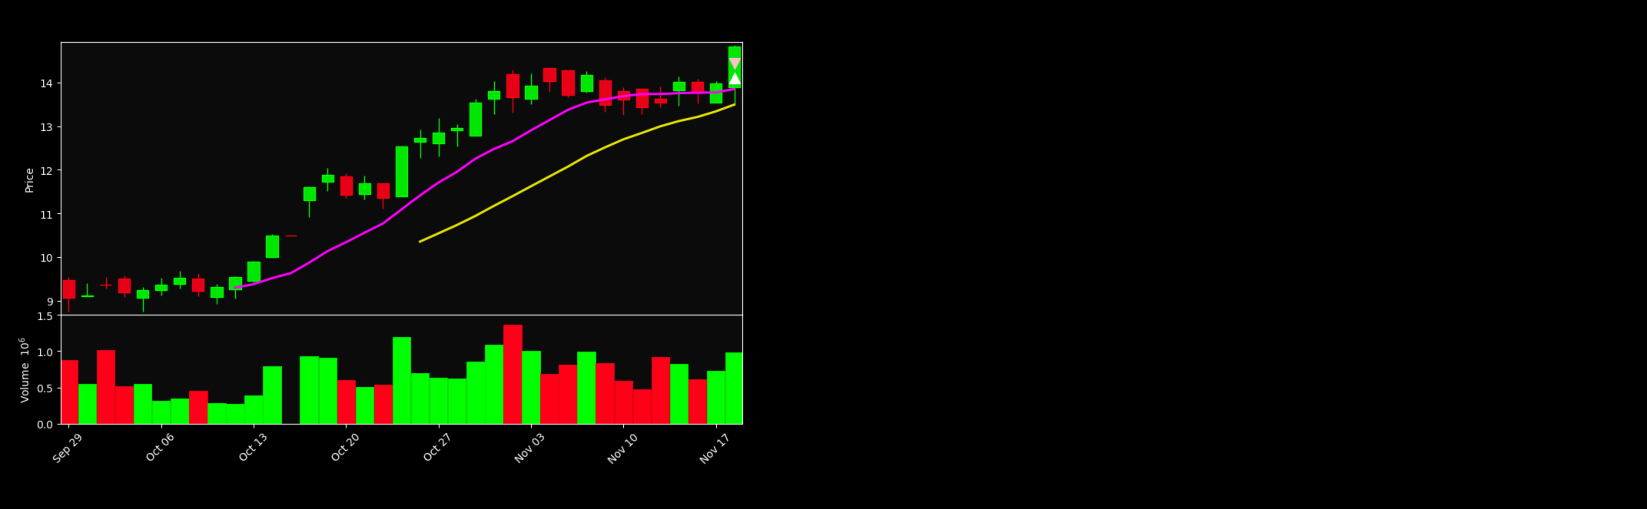

,id,symbol,side,created,qty,price,fees
execTime,,,,,,,
2022-11-17,197287514,BABA,SS_SHORTSELL,2022-11-24T09:30:03.58226,50,77.32,0.99
2022-11-17,197287515,BABA,BC_COVEREDBUY,2022-11-24T09:30:03.583261,50,78.11,0.99


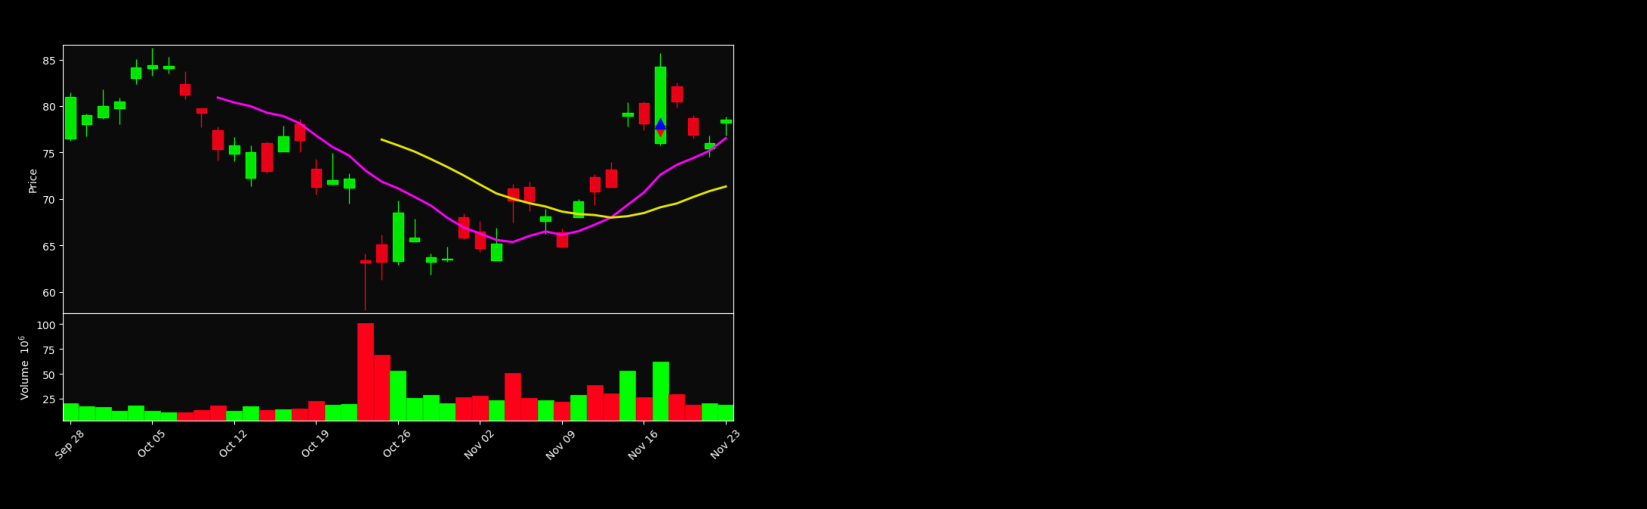

,id,symbol,side,created,qty,price,fees
execTime,,,,,,,
2022-11-17,197287543,BABA,SS_SHORTSELL,2022-11-24T09:30:03.600261,70,83.54,0.99
2022-11-17,197287548,BABA,BC_COVEREDBUY,2022-11-24T09:30:03.602258,70,85.09,0.99


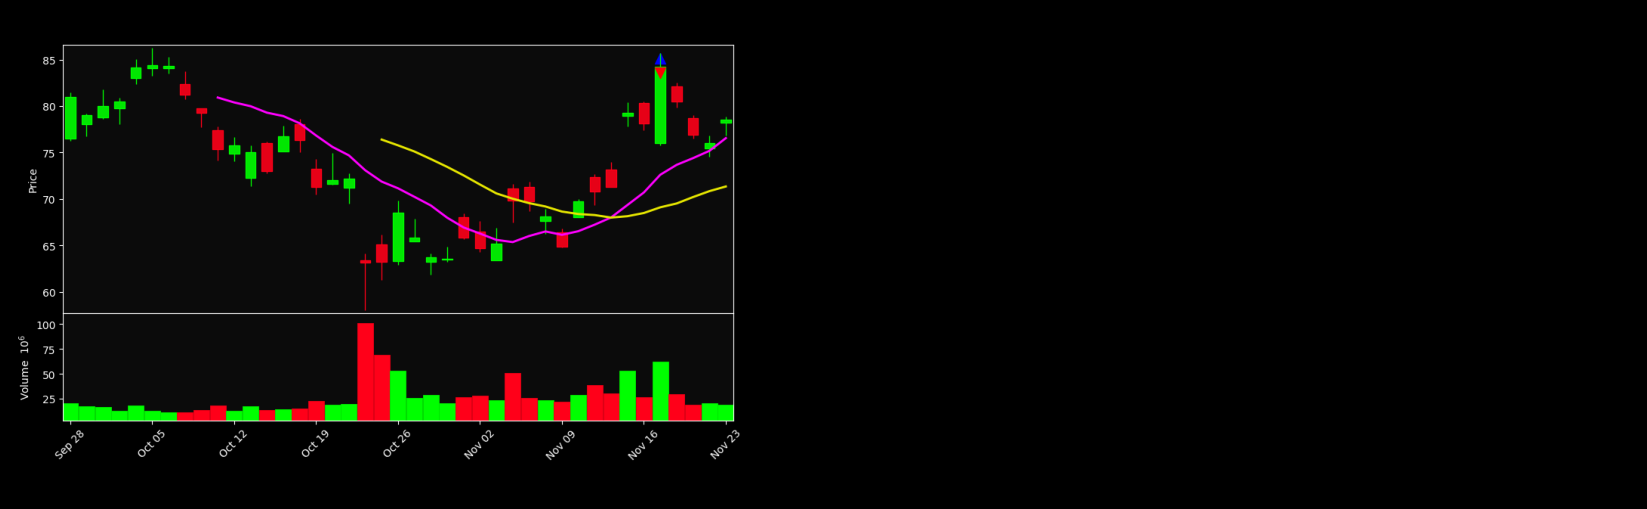

,id,symbol,side,created,qty,price,fees
execTime,,,,,,,
2022-11-17,197287558,BABA,SS_SHORTSELL,2022-11-24T09:30:03.608258,30,84.70,0.99
2022-11-17,197287560,BABA,SS_SHORTSELL,2022-11-24T09:30:03.60926,30,84.61,0.99
2022-11-17,197287564,BABA,SS_SHORTSELL,2022-11-24T09:30:03.61126,30,84.43,0.99
2022-11-17,197287576,BABA,BC_COVEREDBUY,2022-11-24T09:30:03.61726,90,84.53,0.99


ValueError: x and y must be the same size

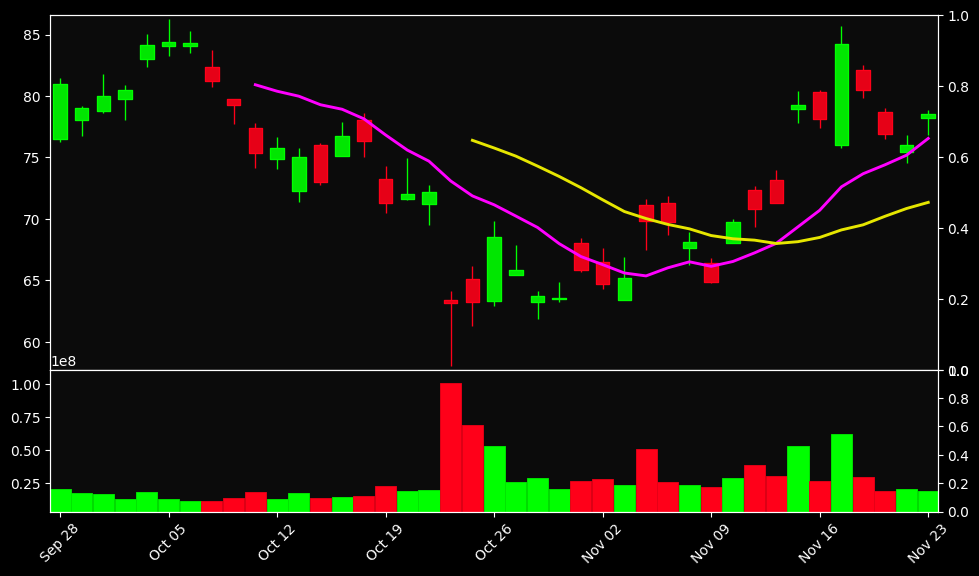

In [36]:
entryOffset = 0
mc = mpf.make_marketcolors(up='#00ff00',down='#ff0019',inherit=True)
mstyledaily  = mpf.make_mpf_style(
    base_mpf_style='nightclouds', 
    mavcolors=['magenta','#e6e600','red','green'],
    marketcolors=mc,
    gridcolor='#0b0b0b'
  )
mstyleintra = mpf.make_mpf_style(
    base_mpf_style='nightclouds', 
    mavcolors=['magenta','#e6e600','red','green'],
    marketcolors=mc,
    gridcolor='#0b0b0b'
  )

#for each trade
for index, row in df.iterrows():

    # with pd.option_context('display.max_rows', None, 'display.max_columns', None,'display.max_colwidth', -1):
    #     display(row)
        
    ######################################################
    # fetch daily
    ######################################################
    chartDf = getChartDataframe(
        row['symbol'], 
        'd', 
        (row['exitTime'] + pd.DateOffset(days=-50)).strftime('%Y-%m-%d'), 
        (row['exitTime'] + pd.DateOffset(days=100)).strftime('%Y-%m-%d')
      )

    # dfExec = pd.read_json(row["tradeExecutions"])
    # with pd.option_context('display.max_rows', None, 'display.max_columns', None,'display.max_colwidth', -1):
    #     display(chartDf)

    dfExec = pd.DataFrame.from_records(row["tradeExecutions"])
    dfExec['execTime'] = pd.to_datetime(dfExec['execTime']).dt.date
    dfExec['execTime'] = pd.to_datetime(dfExec['execTime'])
    dfExec = dfExec.set_index('execTime')

    # dfExec = dfExec.groupby(dfExec.index, dfExec.side).price.apply(list).reset_index()
    # dfExec = dfExec.groupby(["execTime","side"]).price.apply(list).reset_index()
    # with pd.option_context('display.max_rows', None, 'display.max_columns', None,'display.max_colwidth', -1):
    #   display(dfExec)


    # with pd.option_context('display.max_rows', None, 'display.max_columns', None,'display.max_colwidth', -1):
    #   display(chartDf)

    #chartDf = chartDf.reset_index().merge(dfExec, how='left', left_on="tickTime", right_on="execTime").set_index('tickTime')
    #chartDf.drop('execTime', axis=1, inplace=True)

    with pd.option_context('display.max_rows', None, 'display.max_columns', None,'display.max_colwidth', -1):
      display(dfExec)

    addplot = []
    if ('B_LONG' in dfExec['side'].values):
      signalDf = pd.DataFrame(index=chartDf.index.copy()).reset_index().merge(dfExec.loc[dfExec["side"] == 'B_LONG'], how='left', left_on="tickTime", right_on="execTime").set_index('tickTime')
      addplot.append(mpf.make_addplot(signalDf.filter(['price']), scatter=True,  type='scatter', markersize=100, marker='^', color="white"))
       
    if ('S_SELL' in dfExec['side'].values):
      signalDf = pd.DataFrame(index=chartDf.index.copy()).reset_index().merge(dfExec.loc[dfExec["side"] == 'S_SELL'], how='left', left_on="tickTime", right_on="execTime").set_index('tickTime')
      addplot.append(mpf.make_addplot(signalDf.filter(['price']), scatter=True,  type='scatter', markersize=100, marker='v', color="pink"))

    if ('SS_SHORTSELL' in dfExec['side'].values):
      signalDf = pd.DataFrame(index=chartDf.index.copy()).reset_index().merge(dfExec.loc[dfExec["side"] == 'SS_SHORTSELL'], how='left', left_on="tickTime", right_on="execTime").set_index('tickTime')
      addplot.append(mpf.make_addplot(signalDf.filter(['price']), scatter=True,  type='scatter', markersize=100, marker='v', color="red"))

    if ('BC_COVEREDBUY' in dfExec['side'].values):
      signalDf = pd.DataFrame(index=chartDf.index.copy()).reset_index().merge(dfExec.loc[dfExec["side"] == 'BC_COVEREDBUY'], how='left', left_on="tickTime", right_on="execTime").set_index('tickTime')
      addplot.append(mpf.make_addplot(signalDf.filter(['price']), scatter=True,  type='scatter', markersize=100, marker='^', color="blue"))

    # addplot = [
        # mpf.make_addplot(chartDf['close'].ewm(span=10, adjust=False).mean(), color='magenta'),
        # mpf.make_addplot(chartDf['close'].ewm(span=21, adjust=False).mean(), color='#e6e600'),
        # mpf.make_addplot(chartDf['close'].ewm(span=50, adjust=False).mean(), color='red'),
        # mpf.make_addplot(chartDf['close'].ewm(span=200,adjust=False).mean(), color='green'),
        # mpf.make_addplot(entryPoint1, scatter=True,  type='scatter', markersize=200, marker=entryMarker, color=entryColor),
        # mpf.make_addplot(entryPoint2, scatter=True,  type='scatter', markersize=50, marker='.', color=entryColor)
        
        # mpf.make_addplot(blongDf.filter(['price']), scatter=True,  type='scatter', markersize=100, marker='^', color="white"),
        # mpf.make_addplot(ssellDf.filter(['price']), scatter=True,  type='scatter', markersize=100, marker='v', color="pink")
    # ]

    imgDailyPlot = io.BytesIO()
    mpf.plot(chartDf, 
             type='candle', 
             volume=True, 
             mav=(10,20,50,200),
             tight_layout=True, 
             figratio=(16,9), 
             addplot=addplot,
             savefig=imgDailyPlot,
             style=mstyledaily)
    _ = imgDailyPlot.seek(0)

    img1 = m_img.imread(imgDailyPlot)
    # img2 = m_img.imread(imgIntradayPlot)
    fig = plt.figure(figsize=(21,14))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax1.set_axis_off()
    ax2.set_axis_off()
    ax1.imshow(img1)
    # ax2.imshow(img2)
    plt.show()





In [ ]:

    # addplot = []
    # for index_exec, row_exec in dfExec.iterrows():
    #   addplot.append(
    #     mpf.make_addplot(entryPoint1, scatter=True,  type='scatter', markersize=200, marker=entryMarker, color=entryColor)
    #   )



    addplot = [
        # mpf.make_addplot(chartDf['close'].ewm(span=10, adjust=False).mean(), color='magenta'),
        # mpf.make_addplot(chartDf['close'].ewm(span=21, adjust=False).mean(), color='#e6e600'),
        # mpf.make_addplot(chartDf['close'].ewm(span=50, adjust=False).mean(), color='red'),
        # mpf.make_addplot(chartDf['close'].ewm(span=200,adjust=False).mean(), color='green'),
        # mpf.make_addplot(entryPoint1, scatter=True,  type='scatter', markersize=200, marker=entryMarker, color=entryColor),
        # mpf.make_addplot(entryPoint2, scatter=True,  type='scatter', markersize=50, marker='.', color=entryColor)
    ]

    imgDailyPlot = io.BytesIO()
    mpf.plot(chartDf, 
             type='candle', 
             volume=True, 
             mav=(10,20,50,200),
             tight_layout=True, 
             figratio=(16,9), 
             addplot=addplot,
             savefig=imgDailyPlot,
             style=mstyledaily,
             hlines=dict(hlines=hlines,colors='y',linewidths=1,alpha=0.5,linestyle='-.'),
             vlines=dict(vlines=[entryStr],colors='c',linewidths=4,alpha=0.2))
    _ = imgDailyPlot.seek(0)

    ######################################################
    # fetch intraday
    ######################################################
    start = (entryDate + pd.DateOffset(days=-1)).strftime('%Y-%m-%d')
    end = (entryDate + pd.DateOffset(days=1)).strftime('%Y-%m-%d')

    imgIntradayPlot = io.BytesIO()

    chartDf = getChartDataframe(
        row['symbol'], 
        '3m', 
        (entryDate + pd.DateOffset(days=-1)).strftime('%Y-%m-%d'), 
        (entryDate + pd.DateOffset(days=1)).strftime('%Y-%m-%d')
      )

    if (chartDf is None):
      imgIntradayPlot = 'void.png'
    else:
      chartDf['VWAP'] = (chartDf.volume * (chartDf.high + chartDf.low) / 2).cumsum() / chartDf.volume.cumsum()

    entryStr = entryDate.replace(hour=9, minute=30)

    entryPrice = chartDf.iloc[[idx+entryOffset-1]]['low'].values[0]
    # entryRow = chartDf.loc[chartDf['high'] >= entryPrice & chartDf['low'] <= entryPrice]

    print('entryPrice: ' + str(entryPrice))
    print(chartDf.iloc[[idx+entryOffset-1]]['low'])

    addplot  = [
      mpf.make_addplot(chartDf['VWAP'], color="red"),
      mpf.make_addplot(chartDf['close'].ewm(span=150, adjust=False).mean(), color='green'),
      mpf.make_addplot(chartDf['close'].ewm(span=63, adjust=False).mean(), color='#33ffff'),
      mpf.make_addplot(chartDf['close'].ewm(span=36, adjust=False).mean(), color='#b266ff'),
    ]

    vlines=[entryDate.replace(hour=9, minute=30), entryDate.replace(hour=15, minute=57)]

    mpf.plot(chartDf[start:end], 
          type='candle', 
          volume=True, 
          tight_layout=True, 
          figratio=(16,9),
          savefig=imgIntradayPlot,
          addplot=addplot,
          style=mstyleintra,
          hlines=dict(hlines=hlines,colors='y',linewidths=(0.5),linestyle='-.'),
          vlines=dict(vlines=vlines,colors='c',linewidths=(2),alpha=0.2))
    _ = imgIntradayPlot.seek(0)

    # daily & intraday charts
    img1 = m_img.imread(imgDailyPlot)
    img2 = m_img.imread(imgIntradayPlot)
    fig = plt.figure(figsize=(21,14))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax1.set_axis_off()
    ax2.set_axis_off()
    ax1.imshow(img1)
    ax2.imshow(img2)
    plt.show()